In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
from collections import namedtuple, defaultdict
from paper_sims_util import MCC
from running_wrappers import get_loaders
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
LOADERS = get_loaders()
AlgoParams = namedtuple('AlgoParams', 'stability_samples M pi')
GraphParams = namedtuple('GraphParams', 'N eta p d ratios')
import pandas as pd
import time

In [ ]:
#S-H calculation

# total trials: 50
# for each graph, run MTP2 N_SAMPLE times at 10 seconds each
# graphs, parameters
#for each graph, run MTP2 N_SAMPLES times, (10 seconds)
10 seconds * N_samples * # graphs 
#graphs = 4 * 4 = 16 * trials per graph

In [92]:
run_name = 'DO_p_100_slashedp'
run_ids = range(20)
with open("{}_algo_params.pkl".format(run_name), 'rb') as f:
    algo_params = pickle.load(f)
with open("{}_graph_params_dict.pkl".format(run_name), 'rb') as f:
    graph_params_dict = pickle.load(f)
# graph_params_dict = {
#     'chain': GraphParams(p=20, N=[20, 25, 30, 35, 40], eta=1, ratios=None, d=None), #p, N, eta
#     'star': GraphParams(p=20, d=[10, 15, 20, 25, 30], N=50, eta=1, ratios=None), #p, d, N, eta
#     'random': GraphParams(p=20, d=0.01, ratios=[r/500. for r in [300, 375, 500, 750, 1000]], eta=1, N=None), #p, d, ratio over 500, eta
#     'grid_3D': GraphParams(p=2, ratios=[0.5, 0.85, 1., 1.25, 1.5, 2], eta=2, N=None, d=None), #p, ratio over 524, eta
#     'grid': GraphParams(p=7, ratios=[0.5, 0.85, 1., 1.25, 1.5, 2], eta=2, N=None, d=None) #p, ratio over 529, eta
# }

In [94]:
graph_params_dict = {'chain': GraphParams(N=[25, 50, 100, 200, 500, 1000], eta=1, p=100, d=None, ratios=None), 
                     'star': GraphParams(N=50, eta=1, p=100, d=[2,3, 4, 5], ratios=None), 
                     'random': GraphParams(N=None, eta=1, p=100, d=0.01, ratios=[0.25, 0.5, 1.0, 2.0, 5.0, 10.0]), 
                     'grid': GraphParams(N=None, eta=1, p=10, d=None, ratios=[0.25, 0.5, 1.0, 2.0, 5.0, 10.0])}

In [99]:
def get_points(loaded_data):
    points = defaultdict(lambda: defaultdict(list))
    print(loaded_data.keys())
    for x_label, trials in loaded_data.items(): #x_;
        #print(x_label)
        for trial in trials:
            #print(type(trial))
#             if type(trial) != dict:
#                 continue
            #print(x_label)
            #print(trials.keys())
            omega = trial[0]
            #print(np.sum(omega))
            results = trial[1]
            for algo_name, algo_results in results.items():
                omega_hat = algo_results[0]
                #print(algo_name, np.sum(omega_hat))
                algo_mcc = MCC(omega_hat, omega)
                points[algo_name][x_label].append(algo_mcc)
    return points

In [96]:
def plot_lines(d):
    lines = defaultdict(list)
    x_labels = list(next(iter(d.values())).keys())
    for algo_name, x_label_to_trials in d.items():
        for x_label in x_labels:
            trial_MCCs = x_label_to_trials[x_label]
            lines[algo_name].append(np.mean(trial_MCCs))
    return x_labels, lines

In [97]:
def plot(graph_type, ret = False):
    loaded_data = LOADERS[graph_type](graph_params_dict[graph_type], 
                                  algo_params, 
                                  run_name,
                                  run_ids)
    print('Loaded data')
    points = get_points(loaded_data)
    lines = plot_lines(points)
    if ret:
        return points, lines
    for algo, line in lines[1].items():
        plt.plot(lines[0], line, label=algo)
    plt.title(graph_type)
    plt.legend()
    plt.show()

In [219]:
graph_type = 'chain'
try:
    with open('{}_{}_points_lines.pkl'.format(run_name, graph_type), 'rb') as f:
        points,lines = pickle.load(f)
#     with open('{}_{}_lines_extra.pkl'.format(run_name, graph_type), 'rb') as f:
#         extra = pickle.load(f)
except:
    points, lines = plot(graph_type, True)
    with open('{}_{}_points_lines.pkl'.format(run_name, graph_type), 'wb') as f:
        pickle.dump((dict(points),lines), f)

#### To add additional metrics

In [235]:
from final_algo import SH_lambda_wrapper, new_algo
from paper_sims_util import grid_graph, random_graph, chain, confusion
graph = grid_graph(10)
sh_lambdas = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
lambdas_to_res = defaultdict(list)
start = time.time()
for N in [25,50,100,200, 500, 1000]:
    print(N)
    X = np.random.multivariate_normal(np.zeros(100), np.linalg.inv(graph), N)
    sh_res, _ = SH_lambda_wrapper(X, sh_lambdas)
    for lamb, omega_hat in sh_res.items():
        TP, TN, FP, FN = confusion(omega_hat, graph)
        TPR = TP/(TP + FN)
        FPR = FP/(FP + TN)
        mcc = MCC(omega_hat, graph)
        print(lamb, ":", TPR, FPR, mcc)
        lambdas_to_res[lamb].append(mcc)
#print(lambdas_to_res)
#print(time.time() - start)

25
0.7 : 0.4722222222222222 0.04465408805031446 0.33649048461677994
0.75 : 0.48333333333333334 0.048846960167714885 0.33075477112413393
0.8 : 0.5 0.05262054507337526 0.33066706040128113
0.85 : 0.5055555555555555 0.05681341719077568 0.322646014862077
0.9 : 0.5111111111111111 0.061215932914046124 0.3148279017384123
0.95 : 0.5222222222222223 0.06519916142557652 0.3121325793641534
0.99 : 0.5388888888888889 0.06813417190775681 0.3155590848228732
50
0.7 : 0.8222222222222222 0.04025157232704402 0.5787566226295863
0.75 : 0.8277777777777777 0.04507337526205451 0.5613393684290376
0.8 : 0.8444444444444444 0.04947589098532495 0.5536711423500088
0.85 : 0.85 0.05450733752620545 0.5384832574450262
0.9 : 0.8611111111111112 0.05911949685534591 0.5291659414960642
0.95 : 0.8722222222222222 0.06373165618448637 0.520769011278601
0.99 : 0.8777777777777778 0.06771488469601677 0.5119605126315693
100
0.7 : 0.9555555555555556 0.038364779874213835 0.6654235792399161
0.75 : 0.9555555555555556 0.04360587002096436 

In [236]:
SH_best_lambdas = []
SH_best_res = []
for i in range(6):
    N_res = []
    for l in lambdas_to_res.keys():
        N_res.append(lambdas_to_res[l][i])
    best = max(N_res)
    best_l = list(lambdas_to_res.keys())[np.argmax(N_res)]
    SH_best_lambdas.append(best_l)
    SH_best_res.append(best)

In [238]:
print(SH_best_res)
print(SH_best_lambdas)

[0.33649048461677994, 0.5787566226295863, 0.6654235792399161, 0.6946779037976534, 0.6864658855770449, 0.6804764557193776]
[0.7, 0.7, 0.7, 0.7, 0.7, 0.7]


In [249]:
from final_algo import new_algo
graph = grid_graph(10)
res = [0.193828297809358, 0.37307241242620476, 0.6849048978277202, 0.894310804995154]
for N in [500, 1000]:
    X = np.random.multivariate_normal(np.zeros(100), np.linalg.inv(graph), N)
    omega_hat = new_algo(X, 0.85)
    TP, TN, FP, FN = confusion(omega_hat, graph)
    TPR = TP/(TP + FN)
    FPR = FP/(FP + TN)
    mcc = MCC(omega_hat, graph)
    print(TPR, FPR, mcc)
    res.append(mcc)

Running new algorithm
N=500, M=196
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4
1.0 0.0 1.0
Running new algorithm
N=1000, M=354
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4
1.0 0.0 1.0


In [250]:
res

[0.193828297809358,
 0.37307241242620476,
 0.6849048978277202,
 0.894310804995154,
 1.0,
 1.0]

In [282]:
lines[1]['SH_0.7'] = SH_best_res
lines[1]['our_85'] = res

In [287]:
with open('grid_ALL_lines.pkl', 'wb') as f:
    pickle.dump(lines, f)

### Generate Plot

In [277]:
graph_type = 'grid'
try:
    with open('{}_{}_points_lines.pkl'.format(run_name, graph_type), 'rb') as f:
        points,lines = pickle.load(f)
#     with open('{}_{}_lines_extra.pkl'.format(run_name, graph_type), 'rb') as f:
#         extra = pickle.load(f)
except:
    points, lines = plot(graph_type, True)
    with open('{}_{}_points_lines.pkl'.format(run_name, graph_type), 'wb') as f:
        pickle.dump((dict(points),lines), f)

In [284]:
tups = []
for algo_name in lines[1].keys():
    for t in zip(lines[0], lines[1][algo_name]):
        tups.append((algo_name,) + t)

In [285]:
df = pd.DataFrame(tups, columns = ['Algorithm', 'N', 'MCC'])

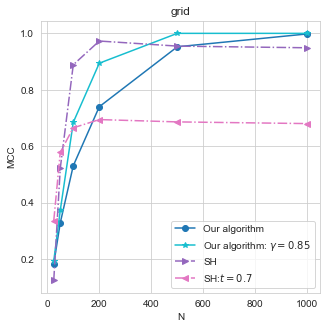

In [291]:
groupby = df.groupby('Algorithm')
labels = {'our': 'Our algorithm', 
          'SH_0.7': 'SH:' + r'$t=0.7$', 
          'SH': 'SH', 
          'nbsel': 'nbsel', 
          'glasso': 'glasso', 
          'anand': 'CMIT',
          'our_85':  "Our algorithm: " + r'$\gamma=0.85$'}
markers = {'our': 'o', 'SH_0.7': '<', 'SH': '>', 'nbsel': '^', 'glasso': 'v', 'anand': 'd', 'our_85': '*'}
linestyles = {'our': 'solid', 
              'SH_0.7': 'dashdot', 
              'SH': 'dashdot', 
              'nbsel': 'dotted', 
              'glasso': (0, (3, 1, 1, 1)), 
              'anand': 'dashed',
              'our_85': 'solid'}
colors = {
    'our': 'C0',
    'glasso': 'C1',
    'nbsel': 'C2',
    'anand': 'C3',
    'SH': 'C4',
    'SH_0.7': 'C6',
    'our_85': 'C9'
}
sns.set_style("whitegrid")
fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
ax.set_yticks(np.linspace(0, 1.0, 6))
#plt.xlim((0,1000))
all_graphs = ['our', 'our_85', 'SH', 'SH_0.7', 'nbsel', 'glasso', 'anand']
main_graphs = ['our', 'SH', 'nbsel', 'glasso', 'anand']
relevant_graphs = ['our', 'our_85', 'SH', 'SH_0.7']
for algo_name in relevant_graphs:
    item = groupby.get_group(algo_name)
    plt.plot(item.N, item.MCC, 
             label = labels[algo_name],
             marker = markers[algo_name],
             linestyle = linestyles[algo_name],
             linewidth=1.5,
             color=colors[algo_name])

plt.legend(loc='lower right')
plt.title(graph_type)
plt.xlabel("N")
plt.ylabel("MCC")
plt.show()
fig.savefig('final_images/{}_relevant.png'.format(graph_type))